# Gender Recognition Lightning RegNet

timm (PyTorch Image Models) provides models based on torch.nn.Module, which allows for smooth integration with the PyTorch ecosystem and frameworks (e.g. PyTorch Lightning).

In [1]:
!pip install lightning 
#!pip install torch-xla 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 17.0 MB/s eta 0:00:00


In [2]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data import random_split, SubsetRandomSampler
from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid

#the latest environement
from lightning.pytorch import LightningModule
from lightning.pytorch import LightningDataModule
from lightning.pytorch import Trainer
import lightning.pytorch as L
print(L.__version__)

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image

2.5.0.post0


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

    # Try these methods to get TPU device information
    import torch_xla.core.xla_model as xm
    
    try:
        # Method 1: Get XLA supported devices
        ldevices = xm.get_xla_supported_devices()
        print("XLA Supported Devices:", ldevices)
        
        # Method 2: Try to get device
        device = xm.xla_device()
        print("XLA Device:", device)
    except Exception as e:
        print("Error getting TPU devices:", e)

In [4]:
dir0='/kaggle/input/gender-recognizer/dataset'

In [5]:
classes=[]
paths=[]
for dirname, _, filenames in os.walk(dir0):
    for filename in filenames:
        classes+=[dirname.split('/')[-1]]
        paths+=[(os.path.join(dirname, filename))]    

In [6]:
dataset0=datasets.ImageFolder(root=dir0)
class_names=dataset0.classes
print(class_names)
print(len(class_names))

['MEN', 'WOMAN']
2


In [7]:
N=list(range(len(classes)))
normal_mapping=dict(zip(class_names,N)) 
reverse_mapping=dict(zip(N,class_names))            

data=pd.DataFrame(columns=['path','class','label'])
data['path']=paths
data['class']=classes
data['label']=data['class'].map(normal_mapping)
print(len(data))

1938


In [8]:
transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [9]:
def create_path_label_list(df):
    path_label_list = []
    for _, row in df.iterrows():
        path = row['path']
        label = row['label']
        path_label_list.append((path, label))
    return path_label_list

path_label = create_path_label_list(data)
path_label = random.sample(path_label,len(path_label))
print(len(path_label))
print(path_label[0:3])

1938
[('/kaggle/input/gender-recognizer/dataset/WOMAN/0376.jpg', 1), ('/kaggle/input/gender-recognizer/dataset/MEN/20240705_113541.jpg', 0), ('/kaggle/input/gender-recognizer/dataset/WOMAN/0288.jpg', 1)]


In [10]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, path_label, transform=None):
        self.path_label = path_label
        self.transform = transform

    def __len__(self):
        return len(self.path_label)

    def __getitem__(self, idx):
        path, label = self.path_label[idx]
        img = Image.open(path).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        return img, label

In [11]:
class ImageDataset(LightningModule):
    def __init__(self, path_label, batch_size=32):
        super().__init__()
        self.path_label = path_label
        self.batch_size = batch_size
        self.transform = transforms.Compose([
            transforms.Resize(224),             # resize shortest side to 224 pixels
            transforms.CenterCrop(224),         # crop longest side to 224 pixels at center            
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])

    def setup(self, stage=None):
        dataset = CustomDataset(self.path_label, self.transform)
        dataset_size = len(dataset)
        train_size = int(0.8 * dataset_size) 
        val_size = dataset_size - train_size
        print(train_size,val_size)

        self.train_dataset = torch.utils.data.Subset(dataset, range(train_size))
        self.val_dataset = torch.utils.data.Subset(dataset, range(train_size, dataset_size))

    def __len__(self):
        if self.train_dataset is not None:
            return len(self.train_dataset)
        elif self.val_dataset is not None:
            return len(self.val_dataset)
        else:
            return 0        

    def __getitem__(self, index):
        if self.train_dataset is not None:
            return self.train_dataset[index]
        elif self.test_dataset is not None:
            return self.test_dataset[index]
        else:
            raise IndexError("Index out of range. The dataset is empty.")

    def train_dataset(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataset(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)


In [12]:
class DataModule(LightningDataModule):
    
    def __init__(self, transform=transform, batch_size=32):
        super().__init__()
        self.root_dir = dir0  
        self.transform = transform
        self.batch_size = batch_size

    def setup(self, stage=None):
        dataset = datasets.ImageFolder(root=self.root_dir, transform=self.transform)
        n_data = len(dataset)
        n_train = int(0.8 * n_data)
        n_test = n_data - n_train
        train_dataset, test_dataset = torch.utils.data.random_split(dataset, [n_train, n_test])
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

        
        def __init__(self):
            super(ConvolutionalNetwork, self).__init__()
            self.conv1 = nn.Conv2d(3, 6, 3, 1)
            self.conv2 = nn.Conv2d(6, 16, 3, 1)
            self.fc1 = nn.Linear(16 * 54 * 54, 120)
            self.fc2 = nn.Linear(120, 84)
            self.fc3 = nn.Linear(84, 20)
            self.fc4 = nn.Linear(20, len(class_names))
    
        def forward(self, X):
            X = F.relu(self.conv1(X))
            X = F.max_pool2d(X, 2, 2)
            X = F.relu(self.conv2(X))
            X = F.max_pool2d(X, 2, 2)
            X = X.view(-1, 16 * 54 * 54)
            X = F.relu(self.fc1(X))
            X = F.relu(self.fc2(X))
            X = F.relu(self.fc3(X))
            X = self.fc4(X)
            return F.log_softmax(X, dim=1)


In [13]:
import timm

class ConvolutionalNetwork(LightningModule):

    def __init__(self, num_classes):
        super().__init__()
        self.base_model = timm.create_model('regnetx_004', 
                                            pretrained=True, 
                                            num_classes=len(class_names))

    def forward(self, x):
        return self.base_model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer
    
    def training_step(self, train_batch, batch_idx):
        X, y = train_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
        X, y = val_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("val_loss", loss)
        self.log("val_acc", acc)

    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("test_loss", loss)
        self.log("test_acc", acc)

In [14]:
if __name__ == '__main__':
    datamodule = DataModule()
    datamodule.setup()
    model = ConvolutionalNetwork(num_classes=len(class_names))

    trainer = L.Trainer(
        max_epochs=30, 
        accelerator="cuda", 
        devices=1) 
    
    trainer.fit(model, datamodule)
    datamodule.setup(stage='test')
    test_loader = datamodule.test_dataloader()
    trainer.test(dataloaders=test_loader)

model.safetensors:   0%|          | 0.00/20.8M [00:00<?, ?B/s]

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
  | Name       | Type   | Params | Mode 
----------------------------------------------
0 | base_model | RegNet | 4.8 M  | train
----------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.093    Total estimated model params size (MB)
474       Modules in train mode
0         Modules in eval mode
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in th

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
INFO: Restoring states from the checkpoint path at /kaggle/working/lightning_logs/version_0/checkpoints/epoch=29-step=1470.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: Loaded model weights from the checkpoint at /kaggle/working/lightning_logs/version_0/checkpoints/epoch=29-step=1470.ckpt
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6804123520851135     │
│         test_loss         │     0.494032084941864     │
└───────────────────────────┴───────────────────────────┘

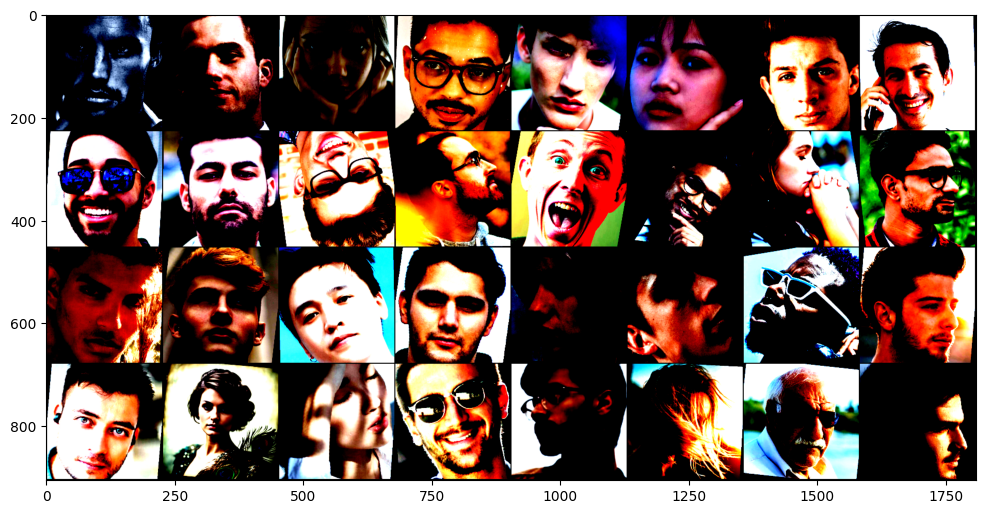

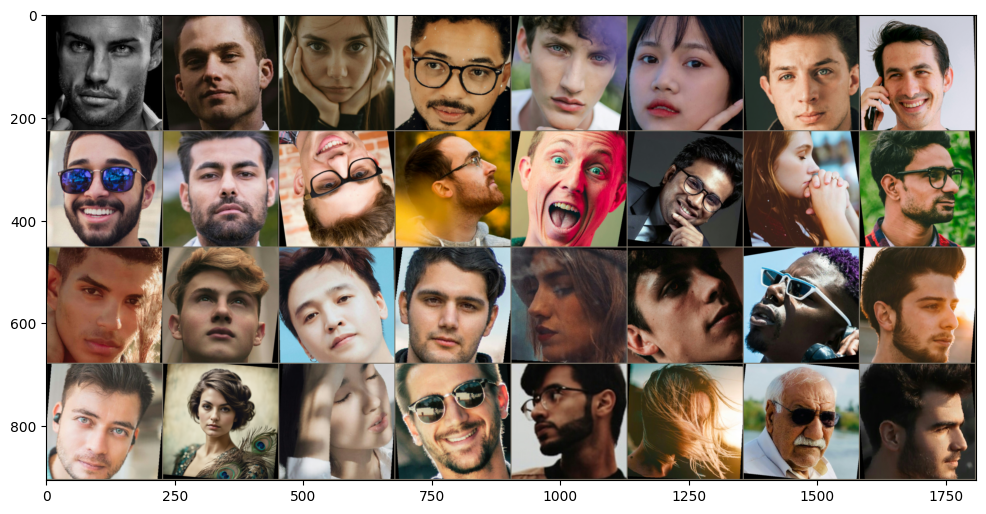

In [15]:
for images, labels in datamodule.test_dataloader():
    break
im=make_grid(images,nrow=8)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

inv_normalize=transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],
                                   std=[1/0.229,1/0.224,1/0.225])
im=inv_normalize(im)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [16]:
device = torch.device("cpu")   #"cuda:0"

model.eval()
y_true=[]
y_pred=[]
with torch.no_grad():
    for test_data in datamodule.test_dataloader():
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

print(classification_report(y_true,y_pred,target_names=class_names,digits=4))

              precision    recall  f1-score   support

         MEN     0.5271    0.9315    0.6733       146
       WOMAN     0.9231    0.4959    0.6452       242

    accuracy                         0.6598       388
   macro avg     0.7251    0.7137    0.6592       388
weighted avg     0.7741    0.6598    0.6557       388



    (epochs,f1_score)=(10,0.6443)